# Physics-Informed Neural Network (PINN) for the 1D Heat Equation

## Overview
This notebook trains a **physics-informed neural network** to solve the 1D heat/diffusion equation on a unit rod.  
Instead of learning only from labeled data, the model minimizes the **PDE residual** and enforces **initial** and **boundary** conditions directly.

## PDE & Conditions
We solve:
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad x \in(0,L), \quad t>0
$$
with:
$$
u(x,0)=30\sin\!\left(\frac{\pi x}{L}\right),\qquad u(0,t)=u(L,t)=0.
$$
The analytical solution used for validation is:
$$
u(x,t)=u_{\max}\,\sin\!\left(\frac{\pi x}{L}\right)\,\exp\!\left(-\alpha\left(\frac{\pi}{L}\right)^2 t\right).
$$

**Defaults (from the code):**
- Domain: $L = 1.0$, $t_{\text{end}} = 1.0$
- Diffusivity: $\alpha = 0.1$
- Scaling at evaluation: $u_{\max} = 30$

## Data Sampling
- **Physics (collocation) points:** 10,000 random $(x,t)$ in the interior
- **Initial condition points:** 1,000 at $t=0$ with target $\sin(\pi x/L)$
- **Boundary condition points:**
  - 1,000 at $x=0$ with target $0$
  - 1,000 at $x=L$ with target $0$

## Model
A fully-connected neural network with Tanh activations:
- Input: $(x,t)$
- Hidden layers: $width = 32, 4$ layers with \texttt{Tanh}
- Output: $u(x,t)$ (normalized)

## PINN Loss
Let $u_{\theta}(x,t)$ be the network output, obtained using autograd..

- **Physics loss:**  
$$
\mathcal{L}_{\text{physics}} =
\left\| \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} \right\|_2^2
$$

- **Initial condition loss:**  
$$
\mathcal{L}_{\text{IC}} =
\left\| u_\theta(x,0) - \sin\!\left( \frac{\pi x}{L} \right) \right\|_2^2
$$

- **Boundary condition loss:** 
$$
\mathcal{L}_{\text{BC}} =
\left\| u_\theta(0,t) \right\|_2^2 + \left\| u_\theta(L,t) \right\|_2^2
$$

- **Total loss:**  
$$
\mathcal{L}_{\text{total}} =
w_{\text{physics}}\,\mathcal{L}_{\text{physics}} + w_{\text{IC}}\,\mathcal{L}_{\text{IC}} + w_{\text{BC}}\,\mathcal{L}_{\text{BC}}
$$
Where $w_{\text{physics}} = w_{\text{IC}} = w_{\text{BC}} = 1.0$.



## Training
1. **Adam optimizer**: 1,000 epochs, lr = $10^{-3}$, \texttt{StepLR(step\_size=200, gamma=0.5)}
2. **L-BFGS refinement**: \texttt{max\_iter=500}, strong Wolfe line search

Seeds are fixed (\texttt{42}) and CuDNN set to deterministic for reproducibility. GPU is used if available.

## Evaluation \& Results
The notebook compares the PINN prediction (rescaled as $u = u_{\max} \cdot u_{\text{norm}}$)
against the analytical solution on a $1000\times1000$ grid and plots:
- Predicted temperature field
- Analytical temperature field
- Absolute error heatmap

**Reported metrics (example run):**
- Final total loss after L-BFGS: $\sim10^{-6}$
- Mean squared error vs. analytical: $\sim9\times10^{-6}$

## How to Use / Modify

- Adjust **physics** via `alpha`, `L`, `t`  

- Change **resolution** via `num_pde_points`, `num_ic_points`, `num_bc_points`  

- Tweak **architecture** with `PinnModel(nb_nods)`  

- Control **training** with learning rates, schedulers, and L-BFGS settings  

- Set output scale at evaluation with `u_max`

## Reproducibility
`set_seed(42)` seeds Python, NumPy, and PyTorch; CuDNN is deterministic;  
`PYTHONHASHSEED` is set for stable hashing.


In [1]:
import torch
import torch.nn as nn

In [2]:
import random
import numpy as np
import os # To set environment variables, useful for some libraries

def set_seed(seed):
    """
    Sets the random seed for reproducibility across different libraries.
    """
    # 1. Set seed for Python's built-in random module
    random.seed(seed)

    # 2. Set seed for NumPy
    np.random.seed(seed)

    # 3. Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed) # For CPU operations
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # For current GPU
        torch.cuda.manual_seed_all(seed) # For all GPUs (if you have multiple)

    # 4. Ensure deterministic behavior for CuDNN (GPU operations)
    #    This can sometimes slightly slow down training, but ensures exact reproducibility.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Disable CuDNN auto-tuner for deterministic ops

    # 5. Set environment variable for Python hashing (affects dicts, sets, etc.)
    os.environ['PYTHONHASHSEED'] = str(seed)

    print(f"Random seed set to {seed} for all relevant libraries.")

MY_RANDOM_SEED = 42
set_seed(MY_RANDOM_SEED)

Random seed set to 42 for all relevant libraries.


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using cuda device


In [4]:
class PinnModel(nn.Module):
    def __init__(self, nb_nods):
        super().__init__()
        self.Pinn=nn.Sequential(
            nn.Linear(2,nb_nods),#input (x,t)
            nn.Tanh(),
            nn.Linear(nb_nods,nb_nods),
            nn.Tanh(),
            nn.Linear(nb_nods,nb_nods),
            nn.Tanh(),
            nn.Linear(nb_nods,nb_nods),
            nn.Tanh(),
            nn.Linear(nb_nods,1)#output u(x,t)
        )
    def forward(self,points):
        return self.Pinn(points)

In [8]:
num_pde_points = 10000  # Number of points for the physics loss
L = 1.0                # Length of the spatial domain in meters
t = 1.0                # End time of the temporal domain in secondes

x_pde = torch.rand(num_pde_points,1)*L
t_pde = torch.rand(num_pde_points,1)*t
pde_points = torch.cat([x_pde, t_pde], dim=1)
pde_points.requires_grad_(True)

tensor([[0.8823, 0.7707],
        [0.9150, 0.0845],
        [0.3829, 0.1995],
        ...,
        [0.2181, 0.0631],
        [0.9120, 0.5879],
        [0.4111, 0.8562]], requires_grad=True)

In [9]:
num_ic_points = 1000

x_ic = torch.rand(num_ic_points,1)*L
t_ic = torch.zeros_like(x_ic)
u_ic_normalized = torch.sin(torch.pi * x_ic / L) 


ic_points = torch.cat([x_ic,t_ic,u_ic_normalized],dim=1)
ic_points.requires_grad_(True)

tensor([[0.6520, 0.0000, 0.8881],
        [0.1211, 0.0000, 0.3715],
        [0.2255, 0.0000, 0.6506],
        ...,
        [0.9544, 0.0000, 0.1429],
        [0.9766, 0.0000, 0.0734],
        [0.1704, 0.0000, 0.5102]], requires_grad=True)

In [10]:
num_bc_points = 1000
t_bc = torch.rand(num_bc_points,1)*L
x_bc_left = torch.zeros_like(t_bc)
u_bc_left = torch.zeros_like(t_bc)  # Example BC: fixed at 0
x_bc_right = torch.ones_like(t_bc) * L
u_bc_right = torch.zeros_like(t_bc) # Example BC: fixed at 0

bc_points_left = torch.cat([x_bc_left,t_bc, u_bc_left],dim=1)
bc_points_right = torch.cat([x_bc_right,t_bc, u_bc_right],dim=1)

bc_points_left.requires_grad_(True)
bc_points_right.requires_grad_(True)

print(len(bc_points_left))
print(bc_points_left[:,2])

1000
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [11]:
def loss_fn (model, pde_points, ic_points, bc_points_left, bc_points_right, alpha, weight_ic=1.0,
    weight_bc=1.0, weight_physics=1.0):
    pde_points, ic_points, bc_points_left, bc_points_right = pde_points.to(device), ic_points.to(device), bc_points_left.to(device), bc_points_right.to(device)
    
    # 1. Physics Loss (PDE Loss)
    # Get the model's prediction for u(x,t)
    u = model(pde_points)

    # u_t = du/dt
    u_t = torch.autograd.grad(u,pde_points,grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]

    # u_x = du/dx
    u_x = torch.autograd.grad(u,pde_points,grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]

    # u_xx = du^2/ d(x^2)
    u_xx = torch.autograd.grad(u_x, pde_points,grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    
    residual = u_t - alpha * u_xx

    # The physics loss is the Mean Squared Error of the residual
    loss_physics = torch.mean(residual**2)

    # 2. Initial Condition Loss
    # This loss forces the network to match the initial temperature profile.
    u_pred_ic = model(ic_points[:, 0:2])
    loss_ic = torch.mean((u_pred_ic - ic_points[:,2:3])**2)

    # 3. Boundary Condition Loss
    # This loss forces the network to match the temperature at the boundaries.
    u_pred_bc_left = model(bc_points_left[:,0:2])
    u_pred_bc_right = model(bc_points_right[:,0:2])
    
    loss_bc_left = torch.mean((u_pred_bc_left - bc_points_left[:,2:3])**2)
    loss_bc_right = torch.mean((u_pred_bc_right -bc_points_right[:,2:3])**2)
    
    loss_bc = loss_bc_left + loss_bc_right
    
    # 4. Total Loss
    # The total loss is a weighted sum of the components.
    loss_total = weight_physics*loss_physics + weight_ic*loss_ic + weight_bc*loss_bc

    #print(weight_physics)
    
    return loss_total, loss_physics, loss_ic, loss_bc
    

In [12]:
model = PinnModel(32).to(device)

# Adam phase
lr_adam = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
# Option A: StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
num_epochs = 1000
alpha = 0.1

for epoch in range(num_epochs):
    model.train()
    # Pass the closure to the optimizer
    optimizer.zero_grad()
    # Call the loss function with all the generated points
    total_loss, loss_physics, loss_ic, loss_bc = loss_fn(
        model, 
        pde_points,
        ic_points,
        bc_points_left, 
        bc_points_right,
        alpha,
    )
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.item():.4f}, "
              f"Physics Loss: {loss_physics.item():.4f}, IC Loss: {loss_ic.item():.4f}, "
              f"BC Loss: {loss_bc.item():.4f}")

# LBFGS typically expects closure (full batch)
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, history_size=50,
                                   tolerance_grad=1e-9, tolerance_change=1e-12, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    total_loss, loss_physics, loss_ic, loss_bc = loss_fn(
        model, 
        pde_points,
        ic_points,
        bc_points_left, 
        bc_points_right,
        alpha,
    )
    
    total_loss.backward()
    # optional: print inside closure (careful: called many times)
    return total_loss

print("Starting L-BFGS refine...")
optimizer_lbfgs.step(closure)

# final evaluation print
total_loss, loss_physics, loss_ic, loss_bc = loss_fn(
        model, 
        pde_points,
        ic_points,
        bc_points_left, 
        bc_points_right,
        alpha,
    )
print("After L-BFGS | Total {:.6f} | PDE {:.6e} | IC {:.6e} | BC {:.6e}".format(
    total_loss.item(), loss_physics.item(), loss_ic.item(), loss_bc.item()))

print("Training finished.")

C:\Users\elbru\anaconda3\envs\my_new_pytorch_env\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/1000, Total Loss: 0.6842, Physics Loss: 0.0000, IC Loss: 0.6612, BC Loss: 0.0230
Epoch 100/1000, Total Loss: 0.2504, Physics Loss: 0.0192, IC Loss: 0.1650, BC Loss: 0.0663
Epoch 200/1000, Total Loss: 0.0067, Physics Loss: 0.0040, IC Loss: 0.0014, BC Loss: 0.0013
Epoch 300/1000, Total Loss: 0.0023, Physics Loss: 0.0016, IC Loss: 0.0003, BC Loss: 0.0003
Epoch 400/1000, Total Loss: 0.0013, Physics Loss: 0.0011, IC Loss: 0.0001, BC Loss: 0.0001
Epoch 500/1000, Total Loss: 0.0011, Physics Loss: 0.0009, IC Loss: 0.0001, BC Loss: 0.0001
Epoch 600/1000, Total Loss: 0.0009, Physics Loss: 0.0007, IC Loss: 0.0001, BC Loss: 0.0001
Epoch 700/1000, Total Loss: 0.0008, Physics Loss: 0.0007, IC Loss: 0.0001, BC Loss: 0.0001
Epoch 800/1000, Total Loss: 0.0007, Physics Loss: 0.0006, IC Loss: 0.0001, BC Loss: 0.0000
Epoch 900/1000, Total Loss: 0.0006, Physics Loss: 0.0006, IC Loss: 0.0000, BC Loss: 0.0000
Starting L-BFGS refine...
After L-BFGS | Total 0.000001 | PDE 3.657115e-07 | IC 7.107065e-08

In [13]:
def analytical_solution(x, t, alpha, L,u_max):
    """Calculates the analytical solution for the 1D heat equation."""
    term1 = torch.sin(torch.pi * x / L)
    term2 = torch.exp(-alpha * ((torch.pi / L)**2) * t)
    return u_max*term1 * term2

In [14]:
# Assuming your trained model and problem parameters (L, T, alpha) are defined
num_points = 1000
u_max=30
x_eval = torch.linspace(0, L, num_points).reshape(-1, 1)
t_eval = torch.linspace(0, t, num_points).reshape(-1, 1)

xx, tt = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')


# Reshape the grid for the model
x_flat = xx.reshape(-1, 1)
t_flat = tt.reshape(-1, 1)

# Get the model's predictions
model.eval()
with torch.no_grad():
    u_pred_normalized = model(torch.cat([x_flat, t_flat],dim=1).to(device))
    u_pred = u_max * u_pred_normalized

# Reshape predictions back into the grid shape
u_pred_grid = u_pred.reshape(num_points, num_points)

print(u_pred_grid)


tensor([[ 0.0002,  0.0004,  0.0006,  ...,  0.0178,  0.0180,  0.0181],
        [ 0.0944,  0.0945,  0.0945,  ...,  0.0529,  0.0530,  0.0531],
        [ 0.1885,  0.1885,  0.1885,  ...,  0.0879,  0.0880,  0.0881],
        ...,
        [ 0.1912,  0.1909,  0.1907,  ...,  0.0559,  0.0557,  0.0555],
        [ 0.0967,  0.0965,  0.0964,  ...,  0.0205,  0.0204,  0.0202],
        [ 0.0022,  0.0021,  0.0021,  ..., -0.0148, -0.0150, -0.0151]],
       device='cuda:0')


In [15]:
# Calculate the true solution on the grid
u_true_grid = analytical_solution(xx, tt, alpha, L,u_max).to(device)

print(u_true_grid)

# Calculate the mean squared error
error = torch.mean((u_pred_grid - u_true_grid)**2)
print(f"Mean Squared Error: {error.item():.6f}")

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.4342e-02,  9.4249e-02,  9.4156e-02,  ...,  3.5232e-02,
          3.5197e-02,  3.5162e-02],
        [ 1.8868e-01,  1.8850e-01,  1.8831e-01,  ...,  7.0463e-02,
          7.0393e-02,  7.0324e-02],
        ...,
        [ 1.8868e-01,  1.8849e-01,  1.8831e-01,  ...,  7.0462e-02,
          7.0392e-02,  7.0323e-02],
        [ 9.4339e-02,  9.4246e-02,  9.4153e-02,  ...,  3.5231e-02,
          3.5196e-02,  3.5161e-02],
        [-2.6227e-06, -2.6201e-06, -2.6175e-06,  ..., -9.7943e-07,
         -9.7846e-07, -9.7749e-07]], device='cuda:0')
Mean Squared Error: 0.000009


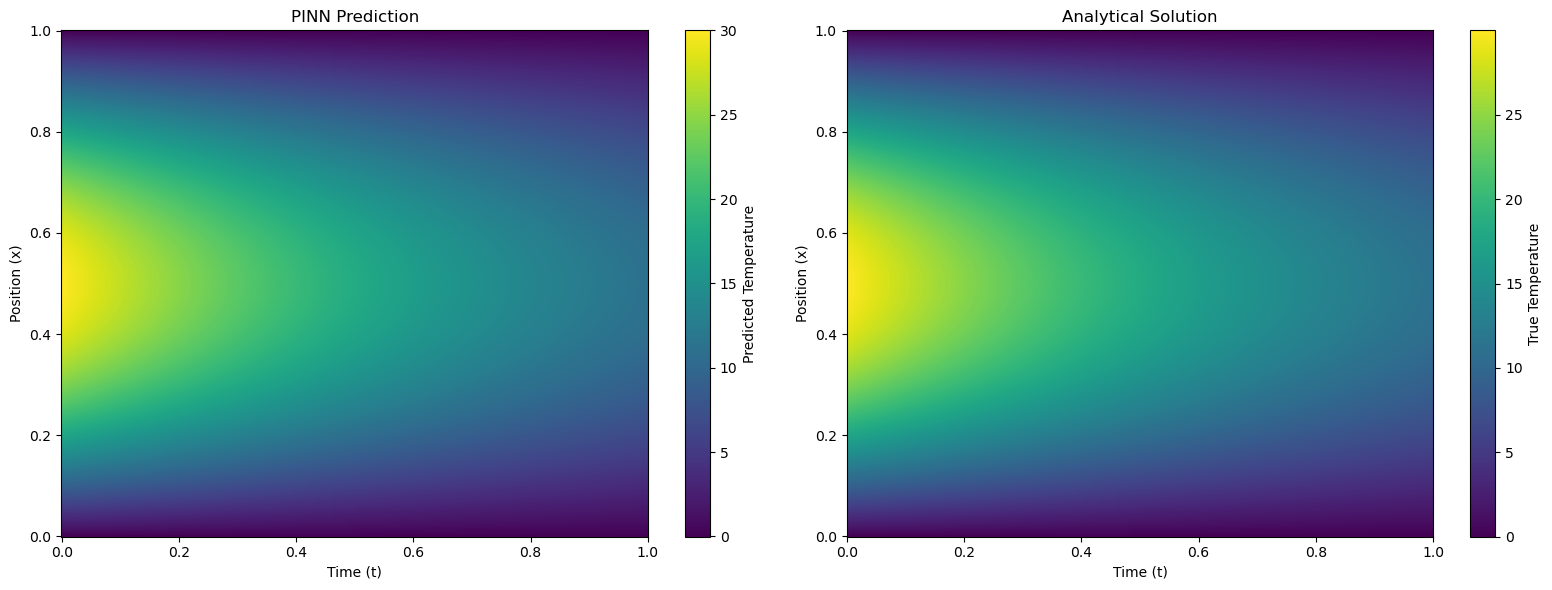

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot model's prediction
im1 = ax1.pcolormesh(tt.cpu(), xx.cpu(), u_pred_grid.cpu(), cmap='viridis')
fig.colorbar(im1, ax=ax1, label='Predicted Temperature in Celcius')
ax1.set_title('PINN Prediction')
ax1.set_xlabel('Time (t) in seconds')
ax1.set_ylabel('Position (x) in meters')

# Plot analytical solution
im2 = ax2.pcolormesh(tt.cpu(), xx.cpu(), u_true_grid.cpu(), cmap='viridis')
fig.colorbar(im2, ax=ax2, label='True Temperature in Celcius')
ax2.set_title('Analytical Solution')
ax2.set_xlabel('Time (t) in seconds')
ax2.set_ylabel('Position (x) in meters')

plt.tight_layout()
plt.show()

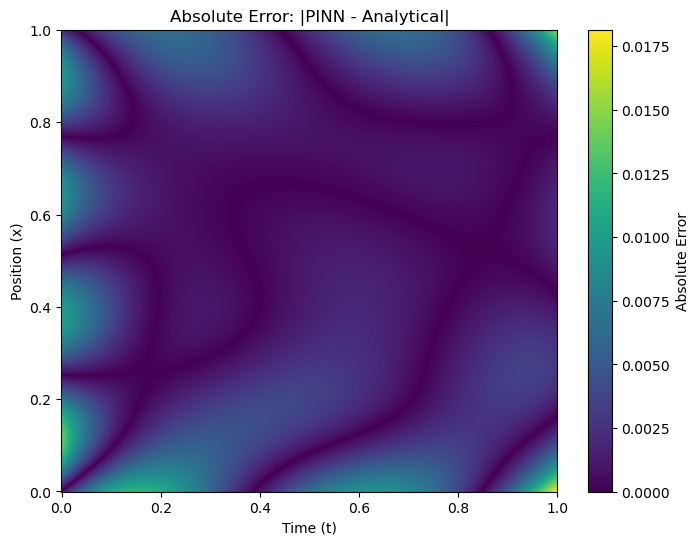

In [17]:
abs_error_grid = torch.abs(u_pred_grid - u_true_grid)

plt.figure(figsize=(8, 6))
im = plt.pcolormesh(tt.cpu(), xx.cpu(), abs_error_grid.cpu(), cmap='viridis')
plt.colorbar(im, label='Absolute Error')
plt.title('Absolute Error: |PINN - Analytical|')
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.show()

In [133]:
torch.save(model.state_dict(), "model_PINN_1D_HE.pth") #We save the model
print("Saved PyTorch Model State to model_PINN_1D_HE.pth")

Saved PyTorch Model State to model_PINN_1D_HE.pth
